<a href="https://colab.research.google.com/github/muqadasrao/Customer_segmentation/blob/main/Customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install pandas numpy scikit-learn matplotlib seaborn scipy yellowbrick plotly

In [21]:
import pandas as pd

#upload dataset
# Specify the encoding explicitly when reading the CSV
data = pd.read_csv('/content/Online_Retail.csv', encoding='latin-1') # Or 'ISO-8859-1' if 'latin-1' doesn't work




In [22]:
#print data
print(data.head(10))

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER       6.0   
1    536365     71053                  WHITE METAL LANTERN       6.0   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER       8.0   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE       6.0   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.       6.0   
5    536365     22752         SET 7 BABUSHKA NESTING BOXES       2.0   
6    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER       6.0   
7    536366     22633               HAND WARMER UNION JACK       6.0   
8    536366     22632            HAND WARMER RED POLKA DOT       6.0   
9    536367     84879        ASSORTED COLOUR BIRD ORNAMENT      32.0   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75  

**Preprocess data**

In [42]:
#preprocess data
data.dropna(inplace=True)
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['UnitPrice'] = data['Quantity'] * data['UnitPrice']

In [47]:
#handling missing values
data.dropna(inplace=True)

# Using SimpleImputer to fill missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
data['UnitPrice'] = imputer.fit_transform(data[['UnitPrice']])

#print data
print("\nAfter Handling Missing Values:")
print(data)



After Handling Missing Values:
       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER       6.0   
1         536365     71053                  WHITE METAL LANTERN       6.0   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER       8.0   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE       6.0   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.       6.0   
...          ...       ...                                  ...       ...   
425158    573305     23558        LANDMARK FRAME LONDON BRIDGE        1.0   
425159    573305     23558        LANDMARK FRAME LONDON BRIDGE        1.0   
425160    573305     23556        LANDMARK FRAME COVENT GARDEN        1.0   
425161   C573306     22796        PHOTO FRAME 3 CLASSIC HANGING      -1.0   
425162   C573306     82483   WOOD 2 DRAWER CABINET WHITE FINISH      -1.0   

               InvoiceDate  UnitPrice  Cust

**Calculating RFM**

In [27]:
# Now, try calculating RFM values again:
snapshot_date = max(data['InvoiceDate']) + pd.Timedelta(days=1)
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'UnitPrice': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalAmount': 'Monetary'
})

print(rfm.head())

            Recency  Frequency  UnitPrice
CustomerID                               
12346.0         284          2       2.08
12347.0          88        124     346.91
12348.0          34         31     178.71
12350.0         269         17      65.30
12352.0          31         80    2124.57


**Normalization using Min-Max Scaling**

In [28]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
rfm_scaled = scaler.fit_transform(rfm)
rfm_scaled = pd.DataFrame(rfm_scaled, columns=rfm.columns)
print(rfm_scaled.head())

    Recency  Frequency  UnitPrice
0  0.854985   0.000167   0.000047
1  0.262840   0.020555   0.008609
2  0.099698   0.005013   0.004433
3  0.809668   0.002674   0.001617
4  0.090634   0.013202   0.052742


**Apply Clustering**

K-Means Clustering

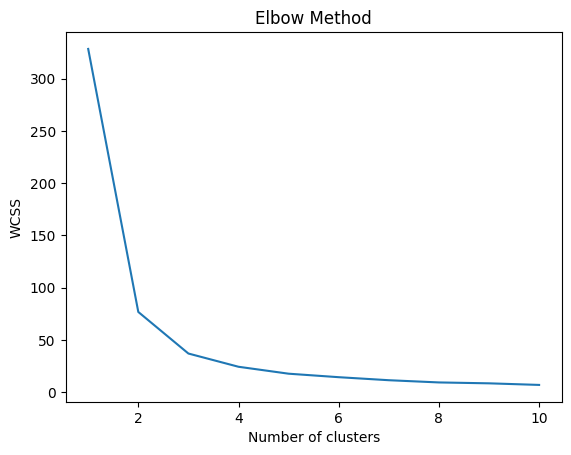

In [29]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow Method to find optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

**DBSCAN**

In [30]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(rfm_scaled)

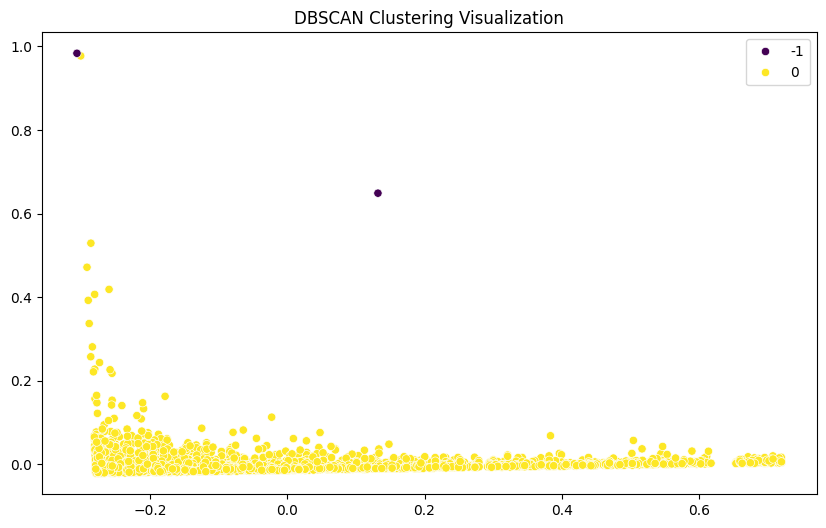

In [31]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=rfm_pca[:, 0], y=rfm_pca[:, 1], hue=dbscan_clusters, palette='viridis')
plt.title('DBSCAN Clustering Visualization')
plt.show()

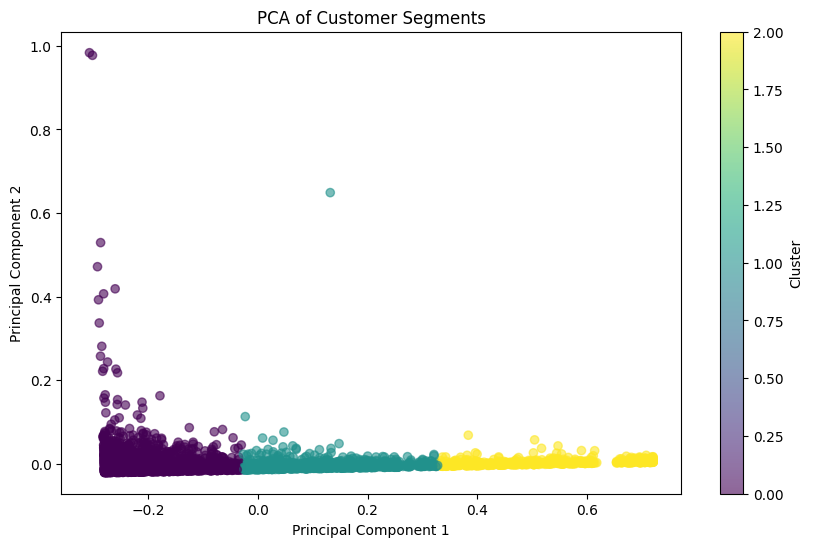

In [34]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# Assume 3 clusters based on the Elbow method (adjust if needed)
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled) # Assign cluster labels to the 'Cluster' column in rfm DataFrame


from sklearn.decomposition import PCA

pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(10, 6))
# Now 'rfm['Cluster']' will exist and should work correctly
plt.scatter(rfm_pca[:, 0], rfm_pca[:, 1], c=rfm['Cluster'], cmap='viridis', alpha=0.6)
plt.title('PCA of Customer Segments')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

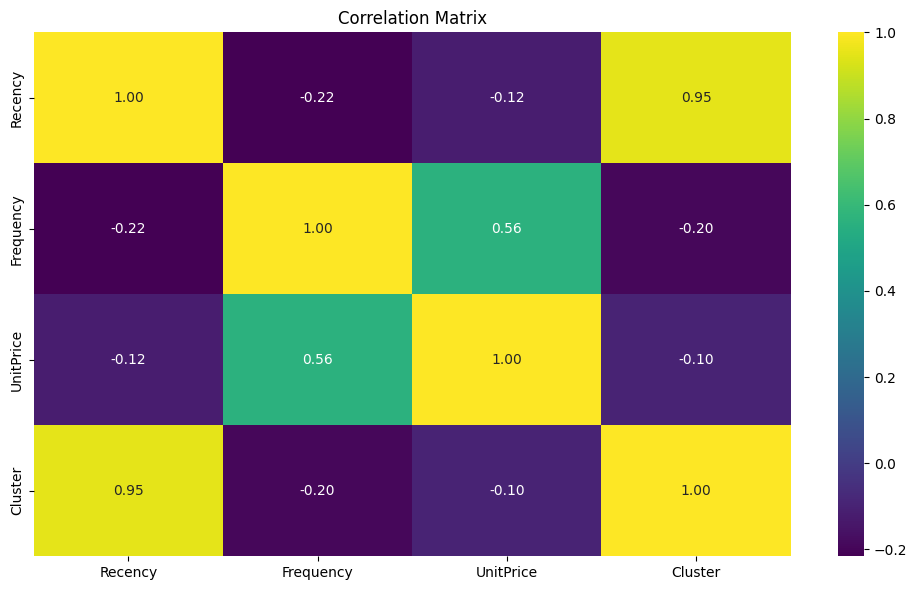

In [36]:
corr = rfm.corr() # Changed X to rfm

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="viridis")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

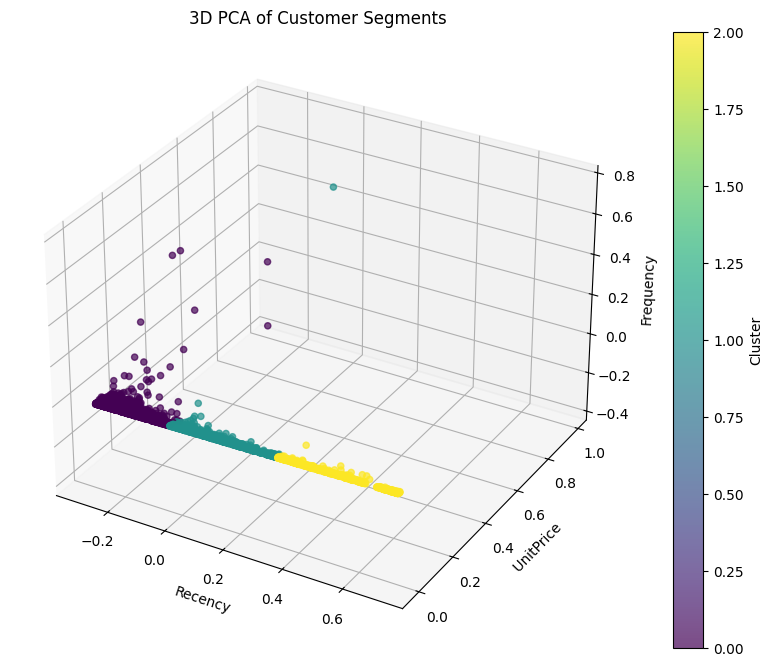

In [40]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Perform PCA for 3D visualization
pca_3d = PCA(n_components=3)
rfm_pca_3d = pca_3d.fit_transform(rfm_scaled)

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(rfm_pca_3d[:, 0], rfm_pca_3d[:, 1], rfm_pca_3d[:, 2],
                     c=rfm['Cluster'], cmap='viridis', alpha=0.7)

# Labels and title
ax.set_title('3D PCA of Customer Segments')
ax.set_xlabel('Recency')
ax.set_ylabel(' UnitPrice')
ax.set_zlabel('Frequency')
plt.colorbar(scatter, label='Cluster')
plt.show()